# Data collection and Description

In [153]:
import numpy as np
from scipy import stats
import pandas as pd
import networkx as nx

import pickle
from tqdm import tqdm

from bs4 import BeautifulSoup

import folium
from folium.plugins import MarkerCluster, FastMarkerCluster
from folium import IFrame

import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.wkt

from IPython.display import display

from geopy.distance import vincenty, great_circle

import json

import re
import unidecode

## Data extraction

In this section we will extract and clean the data from the two datasets we use.
Those dataset are the ged171 dataset from the ucdp(http://ucdp.uu.se/downloads/) and the refugee dataset from the UNHCR (http://popstats.unhcr.org/en/persons_of_concern).

We will keep as much data as possible in this section, so we will avoid removing rows from our dataset.

In later sections we might use subset of the full data in certain analysis.

### Extraction and cleanup of the conflict data (ged171)

In [2]:
CONFLICT_DATA_PATH = "ged171.csv"
raw_conflict_df = pd.read_csv(CONFLICT_DATA_PATH)
display(raw_conflict_df.head(2))

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high
0,4,2010,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2010-09-25,2010-09-25,2,0,0,0,2,2,2
1,5,2011,1,3,715,Government of Yemen (North Yemen) - Civilians,1182,Government of Yemen (North Yemen) - Civilians,123,678.0,...,1,2011-02-19,2011-02-19,0,0,0,0,0,0,2


In [3]:
for year in tqdm(raw_conflict_df.year.unique()):
    for conflict_new_id in raw_conflict_df[raw_conflict_df.year == year].conflict_new_id.unique():
        subdf = raw_conflict_df[(raw_conflict_df.year == year) & (raw_conflict_df.year == year)]

100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


In [4]:
print(raw_conflict_df.columns)

Index(['id', 'year', 'active_year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'dyad_new_id', 'dyad_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'side_b_new_id', 'gwnob', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates', 'adm_1', 'adm_2',
       'latitude', 'longitude', 'geom_wkt', 'priogrid_gid', 'country',
       'country_id', 'region', 'event_clarity', 'date_prec', 'date_start',
       'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
       'deaths_unknown', 'best', 'low', 'high'],
      dtype='object')


In [5]:
# We kept the columns that we found meaningfull from the dataset
# To guide our choice we used the ged171.pdf document that can be found in the repository
KEPT_COLUMNS= ['id', 'year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'gwnob', 'side_b_new_id','side_b',
       'where_prec', 'where_coordinates', 'adm_1', 'adm_2',
       'latitude', 'longitude', 'geom_wkt','country',
       'country_id','date_start', 'date_end', 'deaths_a', 'deaths_b',
       'deaths_civilians',
       'deaths_unknown', 'best'] 

In [6]:
conflict_df = raw_conflict_df[KEPT_COLUMNS]

In [7]:
conflict_df = conflict_df.replace(to_replace="-[0-9]{2}-[0-9]{2}", value="", regex=True)

In [8]:
display(conflict_df.head(5))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,geom_wkt,country,country_id,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,POINT (44.206667 15.354722),Yemen (North Yemen),678,2010,2010,2,0,0,0,2
1,5,2011,3,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,...,POINT (45.036667 12.779444),Yemen (North Yemen),678,2011,2011,0,0,0,0,0
2,6,2011,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,POINT (46.141765 13.786202),Yemen (North Yemen),678,2011,2011,0,0,0,0,0
3,7,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,POINT (46.141765 13.786202),Yemen (North Yemen),678,2012,2012,4,1,0,0,5
4,10,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,POINT (45.300000 15.616667),Yemen (North Yemen),678,2012,2012,0,4,1,0,5


In [9]:
with open('conflict.pickle', 'wb') as out:
    pickle.dump(conflict_df, out)

### Combining events into conflicts

The fundental unit of the dataset is the event. However we are interested in conflicts. Therefore we group events into conflicts and aggregate some of the features:

- `date_start` and `date_end` are combined to obtain a length for each event that will be summed across all events.
- `date_start` becomes the oldest date in the list of start dates of the events in a conflict.
- `date_end` similarly becomes the most recent
- all the deaths counts are summed.
- A list of all sides, countries and coordinates is kept for each conflict

In [10]:
format = '%Y-%m-%d'
conflict_df['date_start'] = pd.to_datetime(conflict_df.date_start, format=format)
conflict_df['date_end'] = pd.to_datetime(conflict_df.date_end, format=format)
conflict_df['duration'] = conflict_df.date_end - conflict_df.date_start

In [11]:
conflicts = conflict_df.groupby('conflict_new_id').agg({
    'duration': 'sum',
    'date_start': 'min',
    'date_end': 'max',
    'deaths_civilians': 'sum',
    'deaths_unknown': 'sum',
    'best': 'sum',
    'latitude': lambda x: list(x),
    'longitude': lambda x: list(x),
    'country': lambda x: set(x),
    'side_a': lambda x: list(x),
    'side_b': lambda x: list(x)
})

In [12]:
names = conflict_df[['conflict_new_id', 'conflict_name']].drop_duplicates()\
                                                         .set_index('conflict_new_id').conflict_name

In [13]:
conflicts['name'] = names

In [14]:
conflicts = conflicts.rename(columns={
    'country': 'countries',
    'side_a': 'sides_a',
    'side_b': 'sides_b',
    'latitude': 'latitudes',
    'longitude': 'longitudes'
})

In [21]:
conflicts.head()

,duration,date_start,date_end,deaths_civilians,deaths_unknown,best,latitudes,longitudes,countries,sides_a,sides_b,name
conflict_new_id,,,,,,,,,,,,
205,0 days,1990-01-01,2016-01-01,92,56,218,"[36.246389, 36.155278, 37.32322, 35.73671, 36....","[46.266389, 45.478889, 48.041134, 46.274843, 4...","{Germany, Iran, Turkey, Iraq}","[Government of Iran, Government of Iran, Gover...","[KDPI, KDPI, KDPI, KDPI, KDPI, KDPI, KDPI, KDP...",Iran:Kurdistan
209,0 days,1989-01-01,2016-01-01,276,221,7786,"[12.782008, 7.780424, 12.75, 8.895, 12.4863, 1...","[123.952024, 123.292649, 124.033333, 125.77527...",{Philippines},"[Government of Philippines, Government of Phil...","[CPP, CPP, CPP, CPP, CPP, CPP, CPP, CPP, CPP, ...",Philippines:Government
218,0 days,1989-01-01,2016-01-01,187,331,1701,"[34.57173, 34.683056, 34.484389, 33.831266, 34...","[73.89724, 76.645, 75.658389, 74.046931, 73.85...","{Pakistan, India}","[Government of India, Government of India, Gov...","[Government of Pakistan, Government of Pakista...",Government of India-Government of Pakistan
220,0 days,1989-01-01,1989-01-01,0,150,150,[-25.29389],[-57.611111],{Paraguay},[Government of Paraguay],[Military faction (forces of Andres Rodriguez)],Paraguay:Government
221,0 days,1989-01-01,2015-01-01,196,1366,4550,"[17.5, 17.5, 17.5, 17.5, 17.5, 17.5, 22.0, 17....","[97.75, 97.75, 97.75, 97.75, 97.75, 97.75, 98....","{Myanmar (Burma), Thailand}","[Government of Myanmar (Burma), Government of ...","[KNU, KNU, KNU, KNU, KNU, DKBA 5, KNU, KNU, KN...",Myanmar (Burma):Karen


### Extraction and cleanup of the refugee data

In [22]:
REFUGEE_DATA_PATH = "unhcr_refugee.csv"
RAW_COLUMN_NAMES = ["year", "country_dest", "origin", "refugee",
                "asylum", "returned_refugee", "internally_displaced", "returned_idp",
                "stateless", "others", "total"
               ]
RAW_COLUMN_TYPE = {"year": int, "coutry_dest" : object, "origin" : object, "refugee" : float,
               "asylum" : float, "returned_refugee" : float, "idp" : float, "returned_idp" : float,
               "stateless" : float, "others" : float, "total" : float
              }
raw_refugee_df = pd.read_csv(REFUGEE_DATA_PATH, skiprows=4, names=RAW_COLUMN_NAMES, dtype=RAW_COLUMN_TYPE, na_values=["*"])
raw_refugee_df.head(5)

,year,country_dest,origin,refugee,asylum,returned_refugee,internally_displaced,returned_idp,stateless,others,total
0,1989,Angola,Dem. Rep. of the Congo,9654.0,NaN,NaN,NaN,NaN,NaN,NaN,9654.0
1,1989,Angola,Namibia,1145.0,NaN,NaN,NaN,NaN,NaN,NaN,1145.0
2,1989,Angola,South Africa,2100.0,NaN,NaN,NaN,NaN,NaN,NaN,2100.0
3,1989,United Arab Emirates,Various/Unknown,70.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0
4,1989,Argentina,Various/Unknown,12634.0,NaN,1060.0,NaN,NaN,NaN,NaN,13694.0


In [23]:
raw_refugee_df.fillna(value=0, inplace=True)
raw_refugee_df.head(5)

,year,country_dest,origin,refugee,asylum,returned_refugee,internally_displaced,returned_idp,stateless,others,total
0,1989,Angola,Dem. Rep. of the Congo,9654.0,0.0,0.0,0.0,0.0,0.0,0.0,9654.0
1,1989,Angola,Namibia,1145.0,0.0,0.0,0.0,0.0,0.0,0.0,1145.0
2,1989,Angola,South Africa,2100.0,0.0,0.0,0.0,0.0,0.0,0.0,2100.0
3,1989,United Arab Emirates,Various/Unknown,70.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0
4,1989,Argentina,Various/Unknown,12634.0,0.0,1060.0,0.0,0.0,0.0,0.0,13694.0


In [24]:
# We drop all the origins that are 'Various/Unknown', we are interested in the country of origins, so
# this identifient is useless to our analysis
raw_refugee_df = raw_refugee_df[(raw_refugee_df.origin != 'Various/Unknown') & (raw_refugee_df.origin != 'Stateless')]

# We also drop the returned columns because it is symptomatic of past refugee and doesn't really fit in our analysis
try:
    raw_refugee_df.drop(['returned_refugee', 'returned_idp'], axis=1, inplace=True)
except: # avoid error if we re-run this code
    pass

display(raw_refugee_df.head(5))

,year,country_dest,origin,refugee,asylum,internally_displaced,stateless,others,total
0,1989,Angola,Dem. Rep. of the Congo,9654.0,0.0,0.0,0.0,0.0,9654.0
1,1989,Angola,Namibia,1145.0,0.0,0.0,0.0,0.0,1145.0
2,1989,Angola,South Africa,2100.0,0.0,0.0,0.0,0.0,2100.0
7,1989,Burundi,Dem. Rep. of the Congo,59557.0,0.0,0.0,0.0,0.0,59557.0
8,1989,Burundi,Rwanda,207486.0,0.0,0.0,0.0,0.0,207486.0


In [25]:
REFUGEE_COLUMNS = ["year", "origin", "refugee", "asylum", "internally_displaced", "stateless", "others", "total"]
refugee_df = pd.DataFrame(columns=REFUGEE_COLUMNS)

for year in tqdm(raw_refugee_df.year.unique()):
    for origin in raw_refugee_df[raw_refugee_df.year == year].origin.unique():
        index = (raw_refugee_df.year == year) & (raw_refugee_df.origin == origin)
        temp_df_no_dest = raw_refugee_df[index].drop(["country_dest"], axis=1)
        sum_series = temp_df_no_dest.sum(numeric_only=True)
        # drop the row if the column of interest are zero (except total, because it might take into account returned)
        if (sum_series[1:5] == 0).all():
            continue
            
        sum_series["year"] = year
        sum_series["origin"] = origin
        sum_series["total"] = sum_series[1:5].sum()
        
        refugee_df = refugee_df.append(sum_series, ignore_index=True)
        
display(refugee_df.head(5))

100%|██████████| 28/28 [01:33<00:00,  3.32s/it]


,year,origin,refugee,asylum,internally_displaced,stateless,others,total
0,1989.0,Dem. Rep. of the Congo,100786.0,0.0,0.0,0.0,0.0,100786.0
1,1989.0,Namibia,3704.0,0.0,0.0,0.0,0.0,3704.0
2,1989.0,South Africa,17137.0,0.0,0.0,0.0,0.0,17137.0
3,1989.0,Rwanda,319501.0,0.0,0.0,0.0,0.0,319501.0
4,1989.0,Uganda,21358.0,0.0,0.0,0.0,0.0,21358.0


In [26]:
with open('refugee.pickle', 'wb') as out:
    pickle.dump(refugee_df, out)

## Creation of Networks from the datasets

Networks are a great way to analyze the information. They can group data in a manner that can be easily visualized.
Also, network theory can be used on them, which can extract meaningful information on the dataset.

In [27]:
with open('conflict.pickle', 'rb') as data_source:
    conflict_df = pickle.load(data_source)

In [28]:
with open('refugee.pickle', 'rb') as data_source:
    refugee_df = pickle.load(data_source)

### Create a network of sides

In [57]:
conflict_df.columns

Index(['id', 'year', 'type_of_violence', 'conflict_new_id', 'conflict_name',
       'side_a_new_id', 'gwnoa', 'side_a', 'gwnob', 'side_b_new_id', 'side_b',
       'where_prec', 'where_coordinates', 'adm_1', 'adm_2', 'latitude',
       'longitude', 'country', 'country_id', 'date_start', 'date_end',
       'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best',
       'geometry'],
      dtype='object')

In [71]:
sides_a = conflict_df[['side_a_new_id', 'side_a']]
sides_a.columns = ['id', 'name']
sides_a = sides_a.set_index('id')

sides_b = conflict_df[['side_b_new_id', 'side_b']]
sides_b.columns = ['id', 'name']
sides_b = sides_b.set_index('id')

sides = pd.concat([sides_a, sides_b]).drop_duplicates()

display('The total number of sides is {}'.format(len(sides)))

'The total number of sides is 1143'

We can use a simple for loop to build the adjancency matrix as the number is not huge

In [205]:
sides_victims = conflict_df.groupby(['side_a_new_id', 'side_b_new_id']).best.sum()
sides_victims = pd.DataFrame(sides_victims).reset_index()
sides_victims = sides_victims.merge(sides, left_on='side_a_new_id', right_index=True)
sides_victims = sides_victims.merge(sides, left_on='side_b_new_id', right_index=True)
sides_victims.columns = ['id_a', 'id_b', 'dead', 'name_a', 'name_b']
sides_victims.sort_values(by='dead', inplace=True, ascending=False)

In [220]:
with open('sides.json', 'w') as f:
    json.dump(sides_victims.to_json(orient='records'), f)

In [206]:
sides_victims.head()

,id_a,id_b,dead,name_a,name_b
184,94,1,511531,Government of Rwanda,Civilians
312,130,303,107344,Government of Afghanistan,Taleban
210,98,97,97435,Government of Eritrea,Government of Ethiopia
387,145,320,60697,Government of Sri Lanka,LTTE
271,116,234,47859,Government of Iraq,IS


In [215]:
from bokeh.charts import Chord
from bokeh.io import show, output_notebook
output_notebook()
chord = Chord(sides_victims[:50], source='id_a', target='id_b', value='dead')
show(chord)

Loading BokehJS ...

AttributeError: 'str' object has no attribute 'references'

Bokeh does not want to display the plot :(.
We export the data to build a visualization 

In [208]:
sides_net = nx.from_pandas_dataframe(sides_victims[:100], source='name_a', target='name_b', edge_attr='dead')

In [209]:
%matplotlib inline

/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/vinz/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


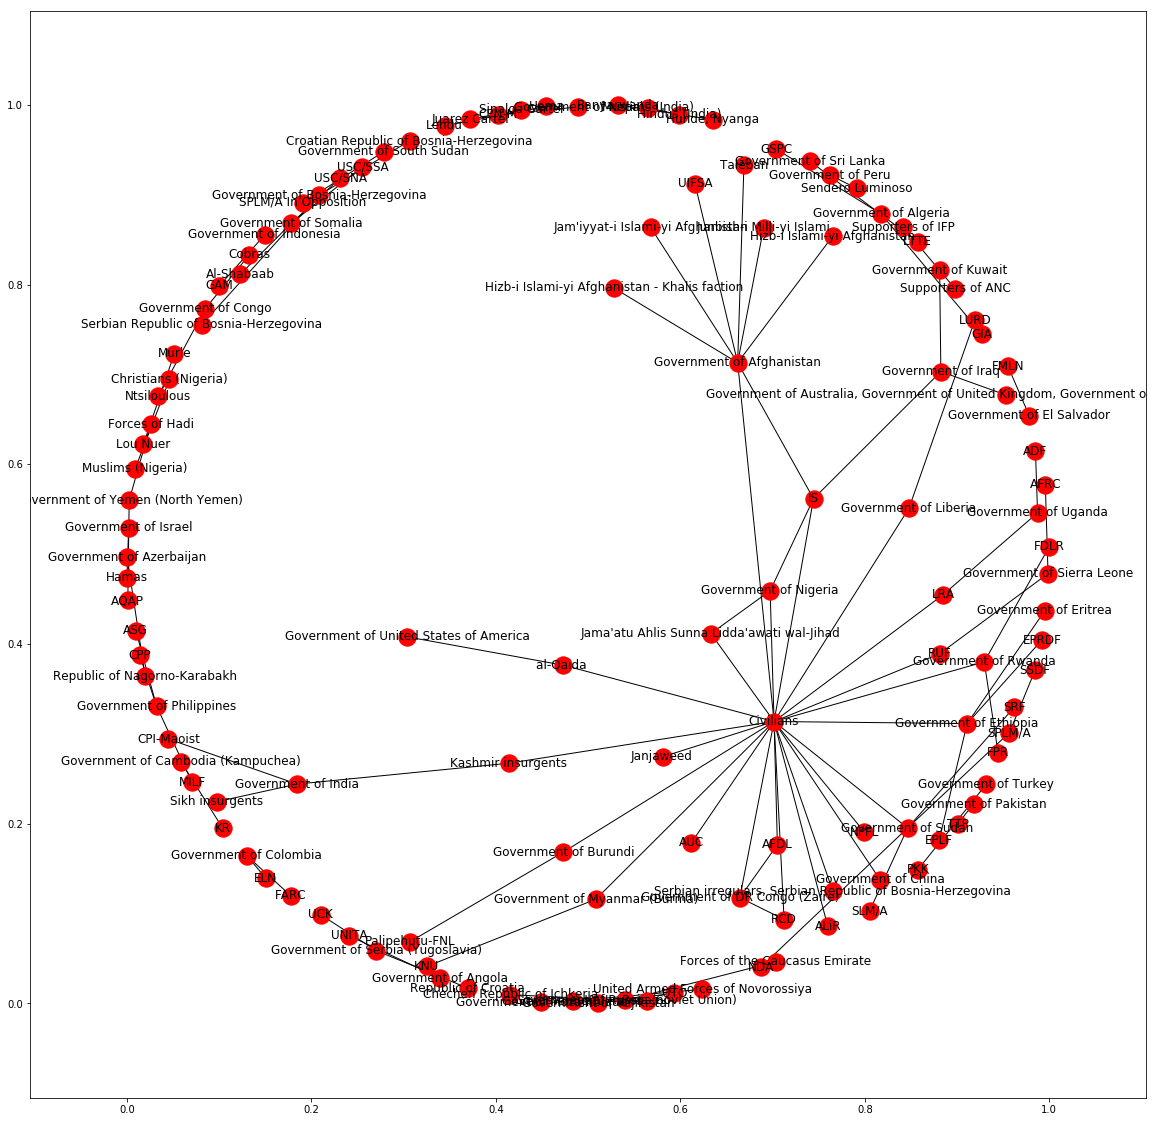

In [210]:
fig, ax = plt.subplots(figsize=(20, 20))
nx.draw_networkx(sides_net, ax=ax)

In [211]:
adj_mat = nx.to_numpy_matrix(sides_net, weight='dead').tolist()

In [214]:
with open('side_adjacency_matrix.json', 'w') as f:
    json.dump(adj_mat, f)

### Create a network with sides and conflicts

We will create a first simple network with sides as nodes and link them with the conflicts they were involved in.

In [29]:
side_network = nx.Graph()

#create a node for each side
side_network.add_nodes_from(conflict_df.side_a_new_id.append(conflict_df.side_b_new_id).unique())

#create an edge for each conflict
for row in conflict_df.itertuples():
    side_network.add_edge(row.side_a_new_id,row.side_b_new_id, weight=row.deaths_a+row.deaths_b)

### Create a network of distances

We will split this network in two types of node: events and conflicts.
Each conflict location will be the centroid of all its events (mean longitude and latitude)
Each event will be linked to it's respective conflict with the edge representing the distance to the center of the conflict.
Each conflicts will be linked together by an edge describing the distance.

For each conflict node, we will also extract the statistics of its event distances with stats.describe.

This network will be used to find spatial relationship between various conflicts.
Also, because each node has a longitude and latitude information, it will be possible to print it on a map and
selectively print links between event and conflicts or between conflicts.

In [30]:
display(conflict_df.head(1))
display(refugee_df.head(1))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,geom_wkt,country,country_id,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,POINT (44.206667 15.354722),Yemen (North Yemen),678,2010,2010,2,0,0,0,2


,year,origin,refugee,asylum,internally_displaced,stateless,others,total
0,1989.0,Dem. Rep. of the Congo,100786.0,0.0,0.0,0.0,0.0,100786.0


In [31]:
# graph indexed
conflict_df = conflict_df.set_index('id')
display(conflict_df.head(2))

,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,side_b,...,geom_wkt,country,country_id,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
id,,,,,,,,,,,,,,,,,,,,,
4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,AQAP,...,POINT (44.206667 15.354722),Yemen (North Yemen),678,2010,2010,2,0,0,0,2
5,2011,3,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,Civilians,...,POINT (45.036667 12.779444),Yemen (North Yemen),678,2011,2011,0,0,0,0,0


In [32]:
def distance_between_nodes(graph, node_1_id, node_2_id):
    """Get distance between two nodes by using their latitude and longitude property"""
    pos_1 = (graph.node[node_1_id]["latitude"], graph.node[node_1_id]["longitude"])
    pos_2 = (graph.node[node_2_id]["latitude"], graph.node[node_2_id]["longitude"])
    # Sometime vincenty doesn't converge, just put None as weight
    try:
        distance = vincenty(pos_1, pos_2).km
    except:
        # Try to get great circle distance instead
        try:
            distance = great_circle(pos_1, pos_2).km
        except:
            print("Error: failed to get distance between node {} and node {}".format(node_1_id, node_2_id))
            print("Node 1 positions: {}".format(pos_1))
            print("Node 2 positions: {}".format(pos_2))
            distance = None
    return distance
    

In [33]:
def get_conflict_lat_long(conflict_id):
    """Get the average latitude and longitude for a particular conflict id"""
    longitude = conflict_df[conflict_df.conflict_new_id == conflict_id].longitude.mean()
    latitude = conflict_df[conflict_df.conflict_new_id == conflict_id].latitude.mean()
    return (latitude, longitude)
    

In [34]:
distance_graph = nx.Graph()

# Create a node for each conflict event
distance_graph.add_nodes_from(conflict_df.index.values, nature="event", year=conflict_df.year)

# Set longitude and latitude for each node
for index in conflict_df.index.values:
    distance_graph.node[index]["longitude"] = conflict_df.loc[index, "longitude"]
    distance_graph.node[index]["latitude"] = conflict_df.loc[index, "latitude"]

# Create a node for each unique conflict, use a special node id to avoid conflict with events
for conflict_id in conflict_df.conflict_new_id.unique():
    conflict_node_name = "conflict_{}".format(conflict_id)
    distance_graph.add_node(conflict_node_name, nature="conflict")
    
    # Get the average position for the conflict
    latitude, longitude = get_conflict_lat_long(conflict_id)
    distance_graph.node[conflict_node_name]["longitude"] = longitude
    distance_graph.node[conflict_node_name]["latitude"] = latitude

In [35]:
# Create edges from event to their conflict
for conflict_id in tqdm(conflict_df.conflict_new_id.unique()):
    conflict_node_name = "conflict_{}".format(conflict_id)
    
    for event_id in conflict_df[conflict_df.conflict_new_id == conflict_id].index.values:
        distance = distance_between_nodes(distance_graph, conflict_node_name, event_id)
        distance_graph.add_edge(conflict_node_name, event_id, weight=distance, nature="event_to_conflict")


100%|██████████| 997/997 [00:05<00:00, 168.15it/s]


In [36]:
# Extract the distance between all conflicts 
for conflict_id_1 in tqdm(conflict_df.conflict_new_id.unique()):
    conflict_node_name_1 = "conflict_{}".format(conflict_id_1)
    
    for conflict_id_2 in conflict_df.conflict_new_id.unique():   
        conflict_node_name_2 = "conflict_{}".format(conflict_id_2)   
        
        # No self loop
        if conflict_id_1 == conflict_id_2:
            pass
        
        # Don't do two times the same edge
        if distance_graph.has_edge(conflict_node_name_1, conflict_node_name_2):
            pass
        
        distance_graph.add_edge(conflict_node_name_1, conflict_node_name_2, 
                  weight = distance_between_nodes(distance_graph, conflict_node_name_1, conflict_node_name_2),
                  nature = "conflict_to_conflict")
        

100%|██████████| 997/997 [00:44<00:00, 22.61it/s]


In [37]:
def get_event_weights(graph, node, nature="event_to_conflict"):
    """Return the event weights for the given nature. Can be an array of natures"""
    edges = [e[2] for e in distance_graph.edges_iter(nbunch=node, data=True)] 
    if type(nature) == str:
        return [d["weight"] for d in edges if d["nature"] == nature]
    else:
        weights = [[] for x in range(len(nature))]
        for index, item in enumerate(nature):
            weights[index] = [d["weight"] for d in edges if d["nature"] == item]
        return weights
    

In [38]:
# Extract conflict statistics
for node in tqdm(distance_graph.nodes()):
    if distance_graph.node[node]["nature"] == "event":
        continue
    
    weights = get_event_weights(distance_graph, node, nature=["event_to_conflict", "conflict_to_conflict"])
    
    distance_graph.node[node]["events_stats"] = stats.describe(weights[0])
    #distance_graph.node[node]["conflicts_stats"] = stats.describe(weights[1])
        

 98%|█████████▊| 133173/136178 [00:00<00:00, 1331429.70it/s]/home/vinz/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/vinz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 136178/136178 [00:01<00:00, 109419.55it/s] 


In [39]:
with open('distance_nx.pickle', 'wb') as out:
    pickle.dump(distance_graph, out)

In [40]:
with open('distance_nx.pickle', 'rb') as data_source:
    distance_graph = pickle.load(data_source) 

## Creation of specific Dataframes

In this section, we create dataframe from our base dataset that combine or merge important information from the datasets.

### Combined displacement and event dataframe

TODO: THIS SECTION IS NOT COMPLETE YET

The goal of this section is to create a dataframe that links the displacement information given by the UNHCR with the events and deaths given by the GED dataset. This will be grouped by year and will keep track of the number of events and of the event identifiers.

In [41]:
with open('conflict.pickle', 'rb') as data_source:
    conflict_df = pickle.load(data_source)

In [42]:
with open('refugee.pickle', 'rb') as data_source:
    refugee_df = pickle.load(data_source)

In [43]:
display(conflict_df.head(2))
display(refugee_df.head(2))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,geom_wkt,country,country_id,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,POINT (44.206667 15.354722),Yemen (North Yemen),678,2010,2010,2,0,0,0,2
1,5,2011,3,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,...,POINT (45.036667 12.779444),Yemen (North Yemen),678,2011,2011,0,0,0,0,0


,year,origin,refugee,asylum,internally_displaced,stateless,others,total
0,1989.0,Dem. Rep. of the Congo,100786.0,0.0,0.0,0.0,0.0,100786.0
1,1989.0,Namibia,3704.0,0.0,0.0,0.0,0.0,3704.0


In [44]:
def extract_gnwo_countries_to_df():
    """Extract the countries from the gnwo and their id from the gnwo.txt file"""
    with open("gnwo.txt", "r") as gnow:
        countries_list = []
        for line in gnow:
            split_line = re.split(r'\t+', line)
            countries_list.append(split_line[0:3])
        # Create a dataframe
        return pd.DataFrame(countries_list, columns=["id", "code" ,"name"])
countries = extract_gnwo_countries_to_df()
display(countries.head(2))

,id,code,name
0,2,USA,United States of America
1,20,CAN,Canada


In [45]:
def is_standard_country_name(country_name, country_df):
    """Check if the country name is in the standard countries dataset"""
    found = False
    for country in countries.name:
        if country_name == country:
            found = True
            break
    return found

In [46]:
def exist_in_substring(country_name, country_df):
    """Returns the id of the country if the substring is in the country_df names, else return none"""
    for data in country_df.itertuples():
        # Force ascii
        country_name = unidecode.unidecode(country_name)
        # manage Dem. Rep. of problem
        country_name = re.sub(r"Dem\. Rep\. of", "", country_name) 
        # manage Rep. of. problem
        country_name = re.sub(r"Rep\. of", "", country_name) 
        # Manage diminutive problem
        country_name = re.sub(r"Dem\.", "Democratic", country_name)
        country_name = re.sub(r"Rep\.", "Republic", country_name)
        # Manage China
        country_name = re.sub(r".*China.*", "China", country_name)
        # Manage Russia
        country_name = re.sub(r"Russian Federation", "Russia", country_name)


        try:
            if country_name in data.name:
                return data
            elif country_name.split()[0] in data.name:
                return data
        except:
            print("EXCEPTION!!!")
            print(country_name, data)
    return None

In [47]:
for country in refugee_df.origin.unique():
    found = is_standard_country_name(country, countries)
    
    # We constructed a dictionnary manually to change the names
    if not found:
        if not exist_in_substring(country, countries):
            print(country)
        #print(country)
        #print(change_country_names_refugee_dict[country])
        
        

Palestinian
Romania
Syrian Arab Rep.
Suriname
Tibetan
Sao Tome and Principe
Cabo Verde
French Guiana
Kyrgyzstan
The former Yugoslav Republic of Macedonia
Puerto Rico
Martinique
Bermuda
Timor-Leste
Cayman Islands
Gibraltar
Turks and Caicos Islands
Niue
French Polynesia
Holy See (the)
Cook Islands
Aruba
Curaçao
British Virgin Islands
Guadeloupe
Anguilla
Norfolk Island
Wallis and Futuna Islands 
Saint-Pierre-et-Miquelon
Svalbard and Jan Mayen


## Visualization

In this section we provide sample visualization of the datasets.
For now they are mainly tests to validate the capacities of the respective libraries with datasets of the size we use.

Obviously, they will be refined during the last segment of the project.

### Examples of visualisation on a map

In [48]:
with open('conflict.pickle', 'rb') as data_source:
    conflict_df = pickle.load(data_source)

In [49]:
geometry = conflict_df['geom_wkt'].map(shapely.wkt.loads)
conflict_df = conflict_df.drop('geom_wkt', axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(conflict_df, crs=crs, geometry=geometry)


#### Display using matplotlib

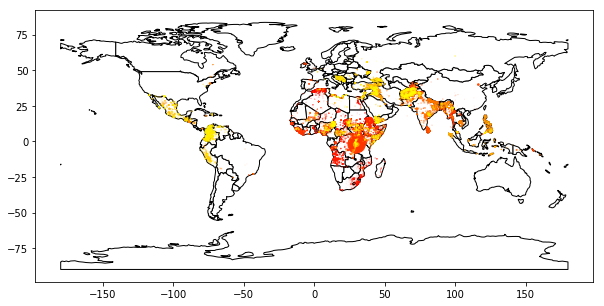

In [50]:
fig, ax = plt.subplots(figsize=(10,5))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=(gdf.loc[:, "best"]/1000), cmap="autumn")
    
plt.show()

#### Display using folium

In [51]:
m = folium.Map(tiles='cartodbpositron')

In [52]:
geojson_gdf = gdf[:50].to_crs(epsg='4326').to_json()
points = folium.features.GeoJson(geojson_gdf)
m.add_child(points)

**Note:** We attemted and succeeded to plot all the events on a map.

The code used is **VERY** slow on the notebook because of the size of the dataset.

Because of this, we used a separate python script to run it ( see "fast_map.py")

The resulting map is named "output_map.html" and can be found in the git folder.